## Вспомогательные функции

In [1]:
# путь к папке с моделями
model_path = "./"

In [2]:
# класс и методы необходимые для SVD разложения
from typing import Union

import torch
from torch import Tensor
from torch.nn import Conv2d, Parameter, Module
from torch.nn.common_types import _size_2_t
import os

class DecomposedConv2d(Conv2d):
    """Extends the Conv2d layer by implementing the singular value decomposition of
    the weight matrix.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = "zeros",
        decomposing: bool = True,
        decomposing_mode: str = "channel",
        device=None,
        dtype=None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
            device,
            dtype,
        )

        n, c, w, h = self.weight.size()
        self.decomposing_modes_dict = {
            "channel": (n, c * w * h),
            "spatial": (n * w, c * h),
        }

        if decomposing:
            self.decompose(decomposing_mode)
        else:
            self.U = None
            self.S = None
            self.Vh = None
            self.decomposing = False

    def decompose(self, decomposing_mode: str) -> None:
        """Decompose the weight matrix in singular value decomposition."""

        if decomposing_mode not in self.decomposing_modes_dict.keys():
            raise ValueError(
                "decomposing_mode must be one of {}, but got decomposing_mode='{}'".format(
                    self.decomposing_modes_dict.keys(), decomposing_mode
                )
            )
        W = self.weight.view(self.decomposing_modes_dict[decomposing_mode])
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)

        self.U = Parameter(U)
        self.S = Parameter(S)
        self.Vh = Parameter(Vh)
        self.register_parameter("weight", None)
        self.decomposing = True

    def compose(self) -> None:
        """Compose the weight matrix from singular value decomposition."""

        W = self.U @ torch.diag(self.S) @ self.Vh
        self.weight = Parameter(
            W.view(
                self.out_channels, self.in_channels // self.groups, *self.kernel_size
            )
        )

        self.register_parameter("U", None)
        self.register_parameter("S", None)
        self.register_parameter("Vh", None)
        self.decomposing = False

    def forward(self, input: Tensor) -> Tensor:

        if self.decomposing:
            W = self.U @ torch.diag(self.S) @ self.Vh
            return self._conv_forward(
                input,
                W.view(
                    self.out_channels,
                    self.in_channels // self.groups,
                    *self.kernel_size
                ),
                self.bias,
            )
        else:
            return self._conv_forward(input, self.weight, self.bias)

    def set_U_S_Vh(self, u: Tensor, s: Tensor, vh: Tensor) -> None:
        """Update U, S, Vh matrices."""

        assert self.decomposing, "for setting U, S and Vh, the model must be decomposed"
        self.U = Parameter(u)
        self.S = Parameter(s)
        self.Vh = Parameter(vh)

def energy_threshold_pruning(conv: DecomposedConv2d, energy_threshold: float) -> None:
    """Prune the weight matrices to the energy_threshold (in-place)."""
    assert conv.decomposing, "for pruning, the model must be decomposed"
    S, indices = conv.S.sort()
    U = conv.U[:, indices]
    Vh = conv.Vh[indices, :]
    sum = (S ** 2).sum()
    threshold = energy_threshold * sum
    for i, s in enumerate(S):
        sum -= s ** 2
        if sum < threshold:
            conv.set_U_S_Vh(U[:, i:].clone(), S[i:].clone(), Vh[i:, :].clone())
            break


def decompose_module(model: Module, decomposing_mode: str = "channel") -> None:
    """Replace Conv2d layers with DecomposedConv2d layers in module (in-place)."""
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            decompose_module(module, decomposing_mode=decomposing_mode)

        if isinstance(module, Conv2d):
            new_module = DecomposedConv2d(
                in_channels=module.in_channels,
                out_channels=module.out_channels,
                kernel_size=module.kernel_size,
                stride=module.stride,
                padding=module.padding,
                dilation=module.dilation,
                groups=module.groups,
                bias=(module.bias is not None),
                padding_mode=module.padding_mode,
                decomposing=False,
            )
            new_module.load_state_dict(module.state_dict())
            new_module.decompose(decomposing_mode=decomposing_mode)
            setattr(model, name, new_module)

def prune_model(model, energy_threshold) -> None:
    """Prune the model weights to the energy_threshold."""
    for module in model.modules():
        if isinstance(module, DecomposedConv2d):
            energy_threshold_pruning(conv=module, energy_threshold=energy_threshold)

def number_of_params(model) -> int:
    """Return number of model parameters."""
    return sum(p.numel() for p in model.parameters())

In [3]:
from eXNN.InnerNeuralTopology import homologies, api
from torchvision.datasets import CIFAR10
import torchvision.transforms as TF

In [4]:
from torchmetrics.classification import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=10)

### Загрузка и предобработка датасетов

In [5]:
import torchvision.transforms as TF

tfm = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = CIFAR10(root='./.cache', train=True, download=True, 
                 transform=tfm) #TF.ToTensor()) 
test_ds = CIFAR10(root='./.cache', train=False, download=False, 
                transform=tfm)#TF.ToTensor())

Files already downloaded and verified


In [6]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=500, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=500, shuffle=False)

## Базовая модель (ResNet18_SVD)

Ниже производится оценка модели ResNet18_SVD по двум пунктам:

1) Разница топологий образов тренировочных и тестовых данных

2) Робастность модели к шумам через оценку разницы топологии зашумлённых и не зашумлённых данных

In [15]:
# загрузка обученной разложенной модели
svd_model_name = 'ResNet18_SVD_channel_O-100.0_H-0.000100.sd.pt'
svd_model = resnet18(num_classes=10)
decompose_module(svd_model, "channel")
svd_model.load_state_dict(torch.load(model_path + svd_model_name,  map_location=device))
print(f"Number of parameters: {number_of_params(svd_model)}")
 
svd_model.eval()

Number of parameters: 12668746


ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [16]:
results_train = api.NetworkHomologies(svd_model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
results_test = api.NetworkHomologies(svd_model, test_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")

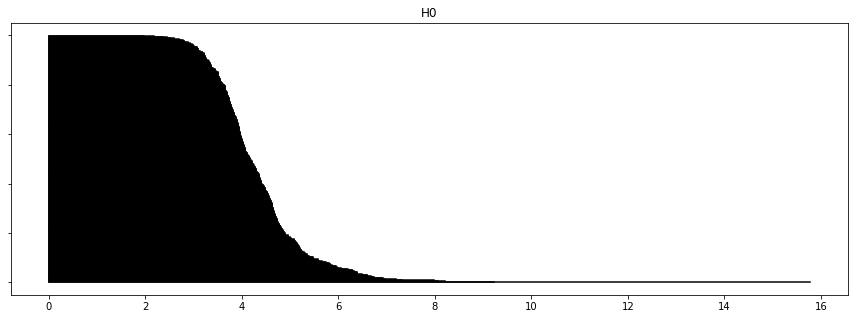

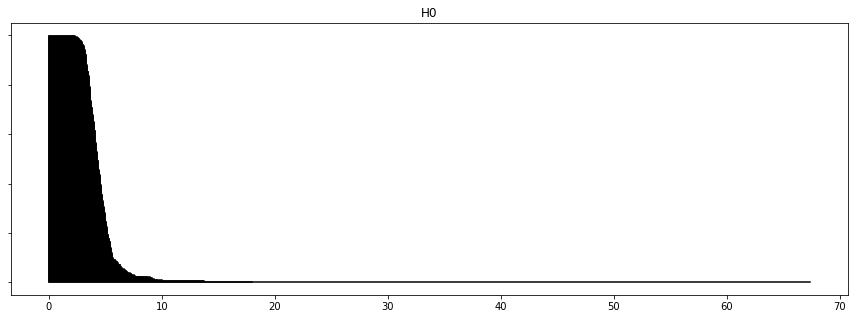

In [17]:
display(results_train["layer4"], results_test["layer4"])

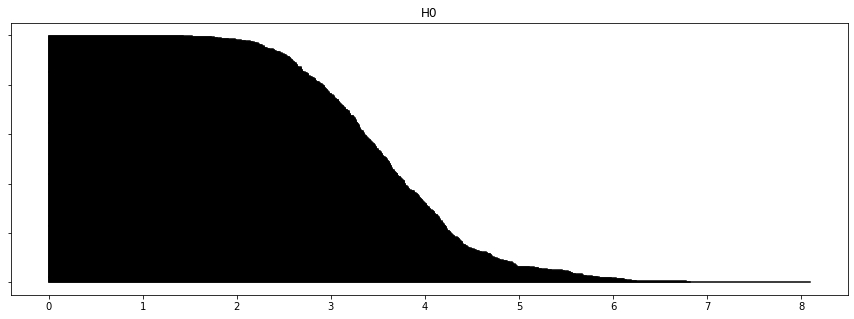

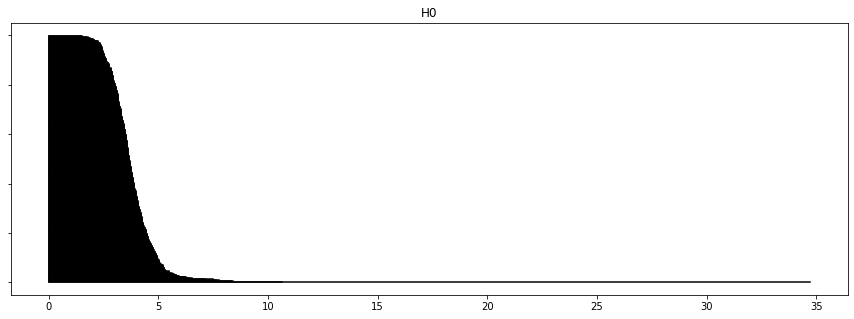

In [18]:
display(results_train["fc"], results_test["fc"])

По графику видно, что топология образов тестовых данных и тренировочных данных существенно отличается - на более, чем 100% - что говорит о том, что модель, скорее всего, выявила существенно неинформативные признаки. С другой стороны, разделенность только растёт, что говорит об устойчивости классификации

### Оценка робастности

In [19]:
results_cleaned = api.NetworkHomologies(svd_model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
noise = torch.randn(train_batch.shape)*(train_batch.max() - train_batch.min())*0.1
results_noised = api.NetworkHomologies(svd_model, train_batch + noise, 
                                       layers = ["layer2", "layer4", "fc"],
                                       hom_type = "sparse", coefs_type = "2")

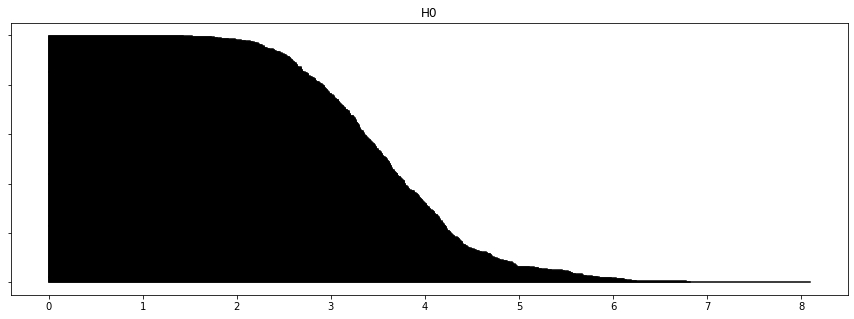

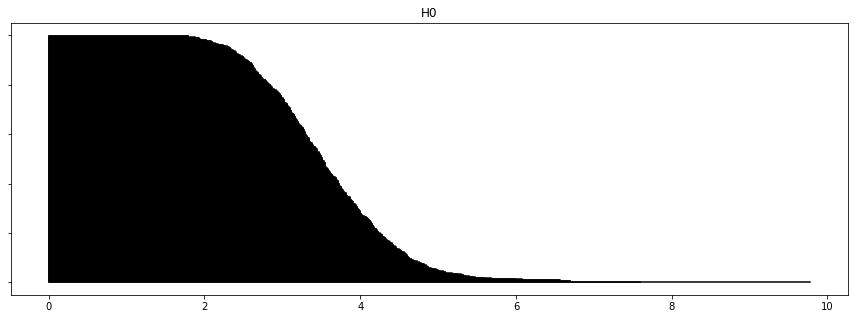

In [20]:
display(results_cleaned["fc"], results_noised["fc"])

По графику видно, что изменение протяжённости баркода при добавлении шума составляет примерно 25%, что говорит о том, что модель уязвима к шумам

## Прореженная модель (ResNet18_SVD_pruned)

Ниже производится оценка модели ResNet18_SVD_pruned по двум пунктам:

1) Разница топологий образов тренировочных и тестовых данных

2) Робастность модели к шумам через оценку разницы топологии зашумлённых и не зашумлённых данных

In [21]:
import copy

#обрезка модели, значения energy_threshold из промежутка (0, 1)
pruned_model = copy.deepcopy(svd_model)
prune_model(model=pruned_model, energy_threshold=0.9)
print(f"Number of parameters: {number_of_params(pruned_model)}")
pruned_model.eval()

Number of parameters: 7206832


ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [22]:
results_train = api.NetworkHomologies(pruned_model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
results_test = api.NetworkHomologies(pruned_model, test_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")

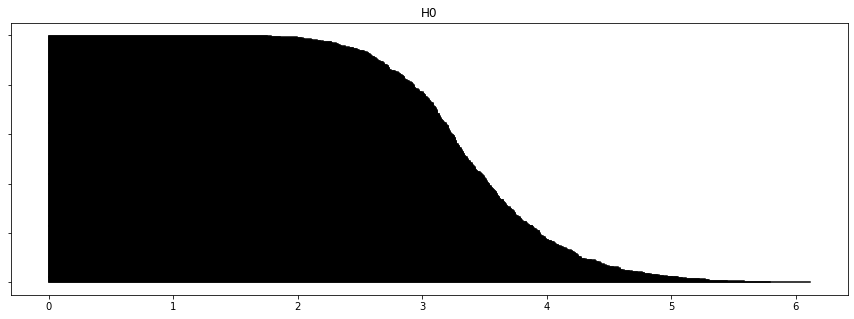

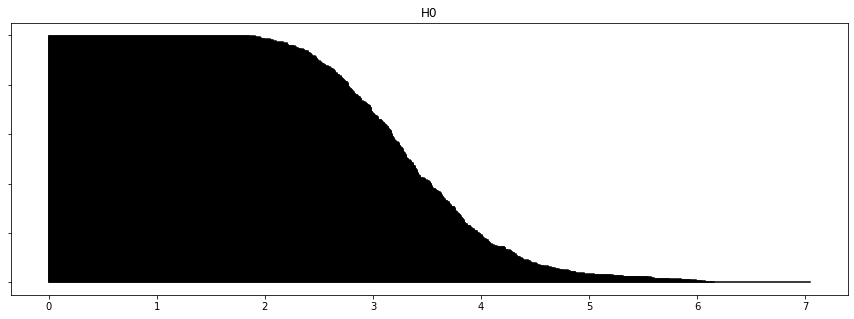

In [23]:
display(results_train["layer4"], results_test["layer4"])

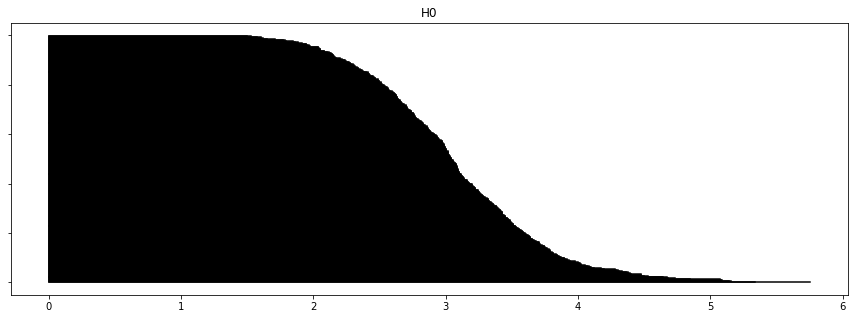

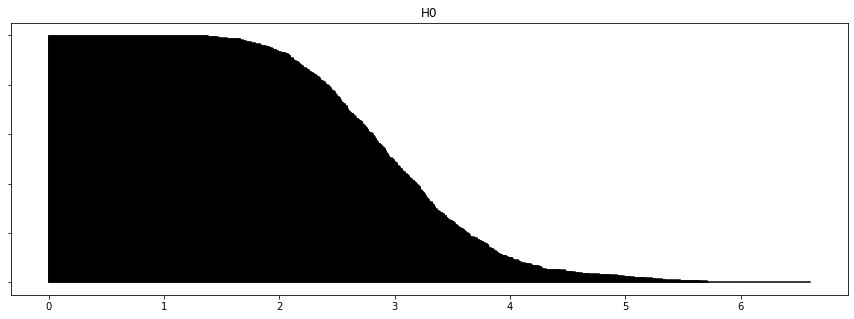

In [24]:
display(results_train["fc"], results_test["fc"])

Из графиков видно, что изменение разделённости между тренировочными и тестовыми данными составляет не более 15%, что говорит о том, что прореживание эффективно убрало из модели неинформативные признаки. С другой стороны, сохранилась закономерность, что разделённость только растёт, что говорит о том, что устойчивость классификации сохранилась

### Оценка робастности

In [25]:
results_cleaned = api.NetworkHomologies(pruned_model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
noise = torch.randn(train_batch.shape)*(train_batch.max() - train_batch.min())*0.1
results_noised = api.NetworkHomologies(pruned_model, train_batch + noise, 
                                       layers = ["layer2", "layer4", "fc"],
                                       hom_type = "sparse", coefs_type = "2")

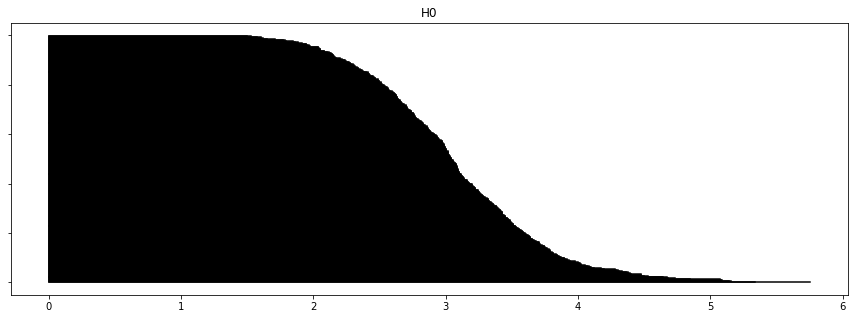

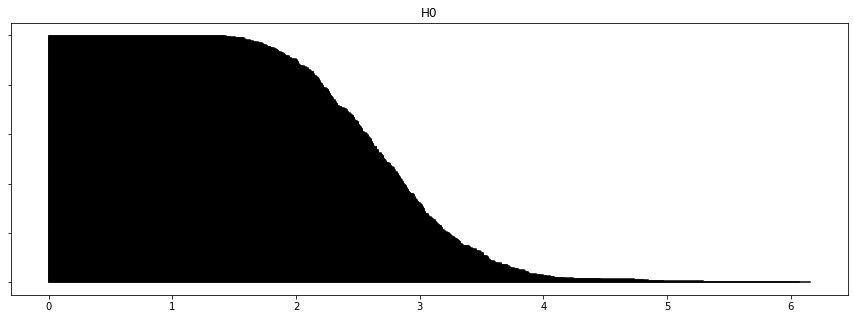

In [26]:
display(results_cleaned["fc"], results_noised["fc"])

По графику видно, что изменение протяженности баркода близко к 0%, что говорит о высоком уровне робастности модели.

## Проверка

Проведём проверку того, что изменение в протяжённости баркодов коррелирует с уровнем шума в данных.

Замерять связь будем с помощью коэффициента корелляции Спирмена - коэффициента, измеряющего монотонную взаимосвязь между переменными. Также дополнительно сопроводим измерение графиком

In [120]:
import numpy as np

def noise_batch(batch, std = 0.1):
    return batch + torch.randn(batch.shape)*std

vals = np.arange(0, 10, 0.25)

min_list = []
max_list = []

diff_list = []

results_cleaned = api.NetworkHomologies(svd_model, train_batch, layers = ["fc"],
                                           hom_type = "sparse", coefs_type = "2")
res0 = np.array([i.get_xdata()[1] - i.get_xdata()[0] for i in results_cleaned["fc"].get_axes()[0].lines])

for i in vals:
    results_noised = api.NetworkHomologies(svd_model, noise_batch(train_batch, i), layers = ["fc"],
                                           hom_type = "sparse", coefs_type = "2")
    
    res = np.array([i.get_xdata()[1] - i.get_xdata()[0] for i in results_noised["fc"].get_axes()[0].lines])
    max_list.append(np.percentile(res, 90))
    min_list.append(np.percentile(res, 10))
    
    diff_list.append(np.mean(np.abs(res - res0)))

Text(0, 0.5, 'barcode mean abs difference')

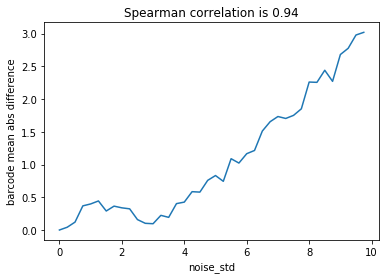

In [123]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

corr = spearmanr(vals, diff_list)[0]
plt.plot(vals, diff_list)
plt.title("Spearman correlation is {}".format(round(corr, 2)))
plt.xlabel("noise_std")
plt.ylabel("barcode mean abs difference")

По графику и величине коэффициента корелляции Спирмена видна сильная монотонная взаимосвязь между уровнем шума в данных и изменением в протяженности баркода

## Влияние коэффициента гомологий на итоговый баркод

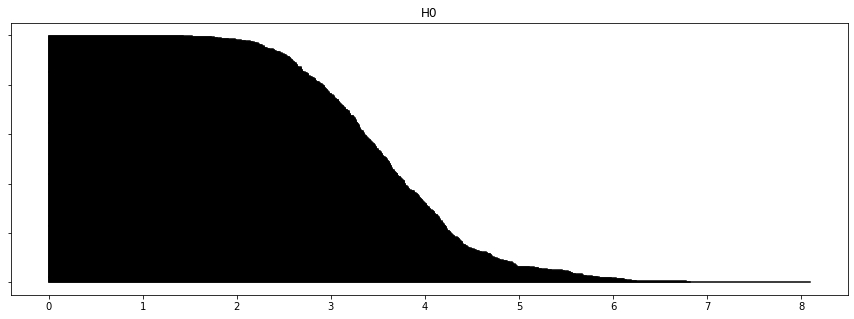

In [134]:
results_cleaned1 = api.NetworkHomologies(svd_model, train_batch, layers = ["fc"],
                                           hom_type = "sparse", coefs_type = "7")

results_cleaned1["fc"]

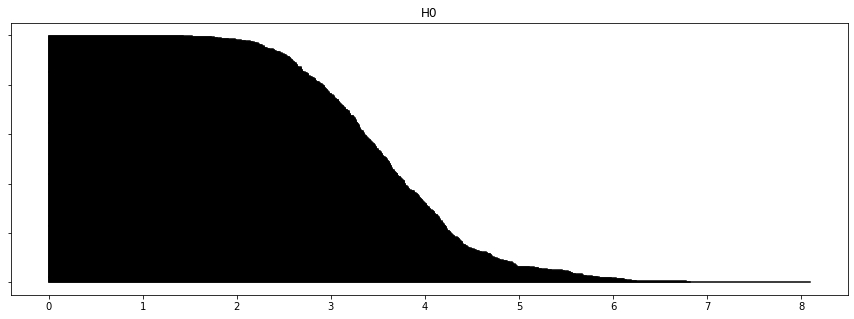

In [133]:
results_cleaned["fc"]

По графикам видно, что различий между результатами с коэффициентами из поля характеристики 2 и коэффициентами из поля характеристики 7 не наблюдается